## Perceptual decision making

### 1. Data generation
$u(t)= \bigg\{ \begin{array}{ll} \bar{u} + \xi (t) & \text{if } 5 \leq t \leq 45 \\  \xi (t) & otherwise \end{array}$

$\bar{u}$ stimulus strength, drawn from a uniformormly from $\pm \frac{3.2}{100} \{1,2,4,8,16\}$ 

$\xi (t)$ is background noise, drawn from a normal distribution with mean 0 and standard deviation 0.03. 

resample for each trial. noise resampled for each time step. 

target $y$ is $sgn(\bar{u})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy.linalg as la
# #%matplotlib inline

In [2]:
# Below snippit taken from PyTorch quickstart tutorial
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [3]:
class DecisionDataset(Dataset):
    def __init__(self, n_trials, n_time_step=75):   
        """
        Generate perceptual decision-making data.

        Parameters
        ----------
        n_trials : int
            Number of trials.
        n_time_step : int (Default: 75)
            Number of time steps.
        Returns
        -------
        u : array, shape (n_trials,n_time_step)
            input 
        y : array, shape (n_trials,n_time_step)
            output 
        """
        strength_choices = (3.2/ 100)  * np.array([1,2,4,8,16, -1,-2,-4,-8,-16])
        n_time_step = 75
        time_step= 20 #ms

        u = np.zeros([n_trials,n_time_step])
        y = np.zeros([n_trials,n_time_step])

        for trial in range(n_trials):
            strength = np.random.choice(strength_choices)

            for t in range(0,n_time_step):
                if t>=5 and t<=45:
                    #noise with std 0.03
                    u[trial,t] = strength + np.random.normal(0,0.03)
                else:
                    u[trial, t] = np.random.normal(0,0.03)

                y[trial, t] = np.sign(strength)
        
        self.u = torch.tensor(u, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.n_trials = n_trials
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, idx):
        return self.u[idx,:], self.y[idx,:]

torch.Size([4, 75]) torch.Size([4, 75])


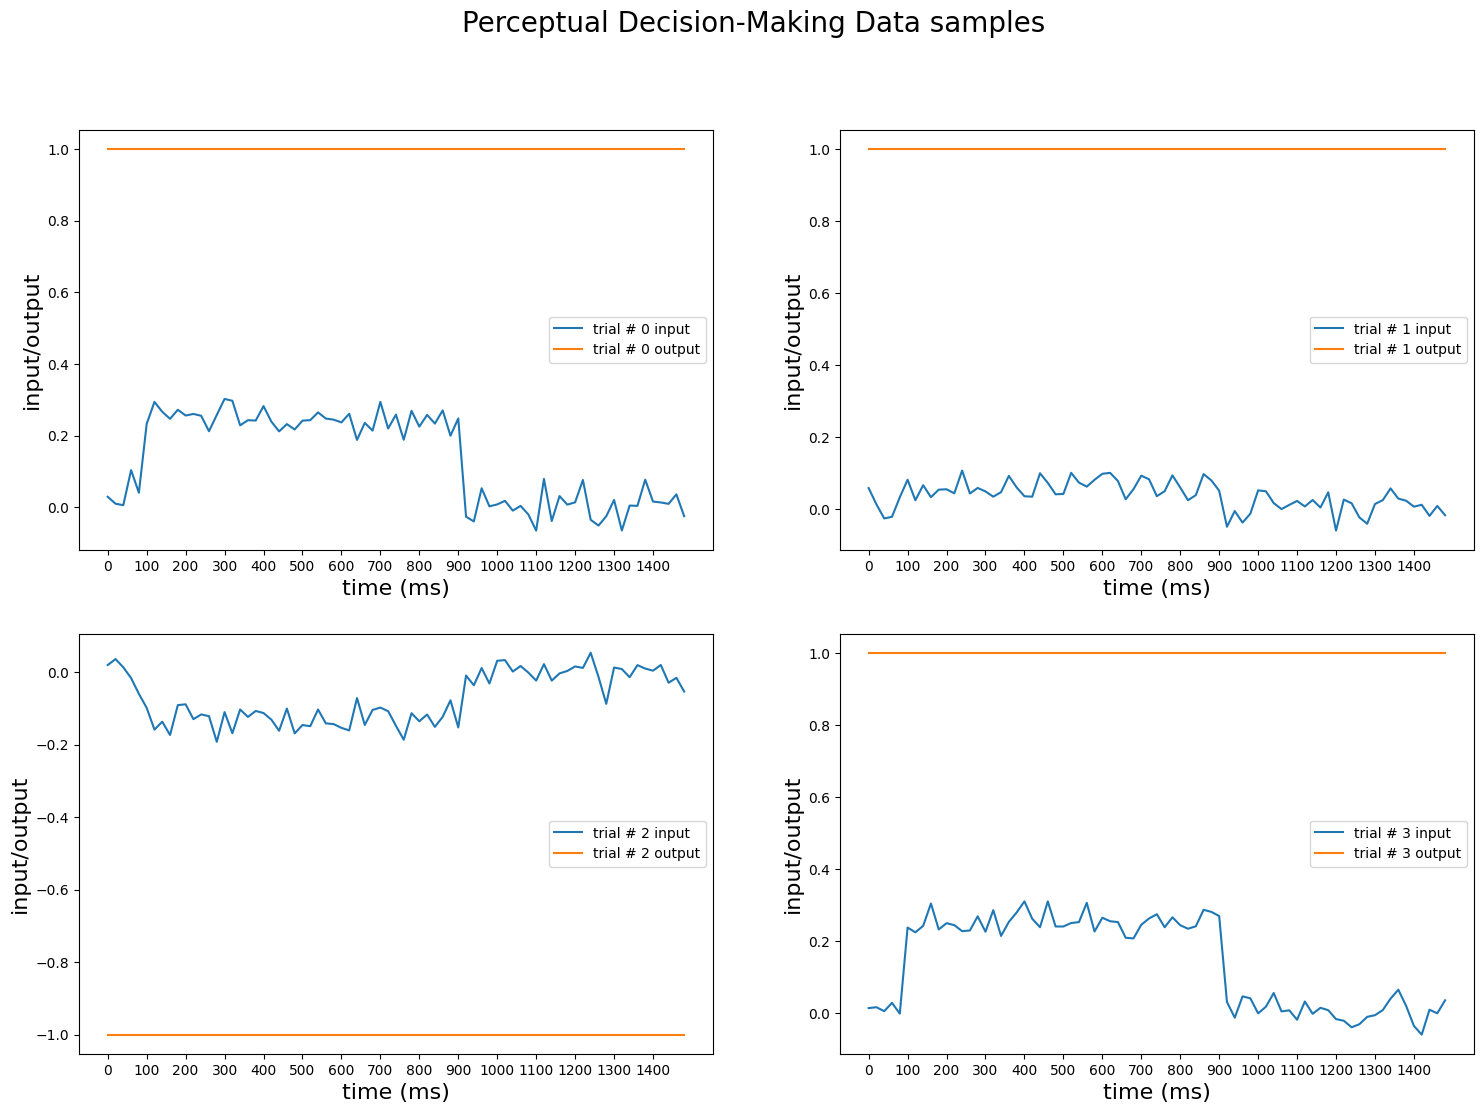

In [4]:
d_data = DecisionDataset(1000)
d_dataloader = DataLoader(d_data, batch_size=4)

u_arr, y_arr = next(iter(d_dataloader))
print(u_arr.shape, y_arr.shape)

plt.figure(figsize=(18,12))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()

### 2. Recurrent neural network
one dimensional input and output, 

N units in the hidden layer, 

left and right connectivity vector $m, n$ trainable parameters, 

fixed input and output weights $I, W$. 

trainable and fixed weights are drawn from standard normal distribution. 

$\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t)$ 

$\phi(x) = \tanh$ 

$\tau = 100 ms$ 
 
$\Delta t = 20 ms$ 

$J = \frac{1}{N} mn^T$ 

Using forward Euler method to solve the differential equation. 

$x_i(t+ \Delta t) = x_i(t) + \frac{1}{\tau}  \Delta t  \bigg( -x_i(t) + \sum_{j=1}^N J_{ij} \phi(x_j(t)) + I_i u(t) \bigg)$ 



In [5]:
import torch
import torch.nn

class RNN(nn.Module):
    
    def __init__(self, network_size=128,rank=1):
        
        super(RNN, self).__init__()
        self.network_size = network_size
        self.rank=rank
        
        # Weight initialization
        #unit rank rnn weight matrix J=mn^T/n
        if rank==1:
            self.m = nn.Parameter(torch.Tensor(self.network_size))
            self.n = nn.Parameter(torch.Tensor(self.network_size))
            self.wi = torch.Tensor(self.network_size)
            self.w = torch.Tensor(self.network_size)
            self.x0= torch.Tensor(self.network_size)
        else:
            self.m = nn.Parameter(torch.Tensor(self.network_size,self.rank))
            self.n = nn.Parameter(torch.Tensor(self.network_size,self.rank))
            self.wi = torch.Tensor(self.network_size, self.rank)
            self.w = torch.Tensor(self.network_size,1)
            self.x0= torch.Tensor(self.network_size,1)
        
                # Parameters for weight update formula
        self.tau = 100 #ms
        self.dt = 20 #ms

        # Activation function
        self.activation = nn.Tanh()
        
        with torch.no_grad():
            self.m.normal_(std=1)
            self.n.normal_(std=1)           
            self.w.normal_(std=4)
            self.x0.zero_()
            self.wi.normal_(std=1)

        # #orthogonalize m and wi
        #     m=self.m.detach().numpy()
        #     wi=self.wi.detach().numpy()
        #     wi= wi - np.dot(m, wi) * m / np.dot(m, m)
        #     wi= wi / la.norm(wi)
        #     self.wi=torch.tensor(wi, dtype=torch.float32)

    def forward(self, u,visible_activity=False):
        input_len=u.size(1)
        batch_size=u.size(0)
        x = self.x0 
        z = torch.zeros(u.shape)
        
        if visible_activity:
            unit_activity = torch.zeros(batch_size, input_len+1, self.network_size)
            unit_activity[:,0,:] = x
        
        #unit rank rnn weight matrix J=mn^T/n
        J = torch.matmul(self.m[:,None], self.n[None,:]) / self.network_size
        
        for i in range(input_len):
            delta_x = (
                -x 
                + torch.matmul(self.activation(x), J) 
                + torch.matmul(u[:,i,None], self.wi[None,:])
            ) * (self.dt / self.tau)
            
            x = x + delta_x
            if visible_activity:
                unit_activity[:,i+1,:] = x
            
            output = torch.matmul(self.activation(x), self.w) / self.network_size            
            z[:, i] = output    
        if visible_activity:
            return z, unit_activity
        else:
            return z

In [6]:
model = RNN(128)
n=model.n
m=model.m
wi=model.wi
w=model.w
x0=model.x0

# print("shape of m:",m.shape)
# print("shape of n:",n.shape)
# print("shape of wi:",wi.shape)
# print("shape of w:",w.shape)
orthogonal_mn=torch.dot(m,n)
print("inner product of m and n:",orthogonal_mn)

orthogonal_mi=torch.dot(m,wi)
print("inner product of m and wi:",orthogonal_mi)

J=torch.matmul(m, n.T) / model.network_size
J=J.detach().numpy()
print('rank of J:',la.matrix_rank(J))

inner product of m and n: tensor(1.3677, grad_fn=<DotBackward0>)
inner product of m and wi: tensor(5.1867, grad_fn=<DotBackward0>)
rank of J: 1


C:\Users\barman\AppData\Local\Temp\ipykernel_13308\2380796085.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  J=torch.matmul(m, n.T) / model.network_size


### 3. Training
train a network of size $N=128$. batch size 32 trals. and specific lost function is defined as the mean squared error of last $T=15$ time step of each trial:

$loss = \frac{1}{32 * 15} \sum_{i=1}^{32} \sum_{t=45}^{60} (z_i(t) - y_i(t))^2$ 

learning rate $0.05$ , Adam optimizer.

In [7]:
# Training function slightly modified from PyTorch quickstart tutorial
def train(dataloader, model, loss_fn, optimizer, T=15):
    size = len(dataloader.dataset)
    optimizer.zero_grad()
    model.train(True)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print("pred shape: ", pred.shape)
        loss = loss_fn(pred[:,-T:], y[:,-T:])

        # print(pred[0, :])
        # print(pred[0, -T:])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
d_dataset = DecisionDataset(1000)
train_dataloader = DataLoader(d_dataset, batch_size=1)
model = RNN(128)
learning_rate = 5e-3
T=15
# model = RNN(128)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(train_dataloader, model, loss_fn, optimizer, T=T)

loss: 1.002635  [    1/ 1000]
loss: 0.989668  [    2/ 1000]
loss: 1.010335  [    3/ 1000]
loss: 1.003006  [    4/ 1000]
loss: 0.998778  [    5/ 1000]
loss: 1.006848  [    6/ 1000]
loss: 1.005453  [    7/ 1000]
loss: 0.999489  [    8/ 1000]
loss: 1.003147  [    9/ 1000]
loss: 1.003870  [   10/ 1000]
loss: 0.997462  [   11/ 1000]
loss: 0.995896  [   12/ 1000]
loss: 1.002170  [   13/ 1000]
loss: 1.002212  [   14/ 1000]
loss: 0.996926  [   15/ 1000]
loss: 1.002419  [   16/ 1000]
loss: 1.005870  [   17/ 1000]
loss: 1.000863  [   18/ 1000]
loss: 1.005533  [   19/ 1000]
loss: 1.018713  [   20/ 1000]
loss: 0.999835  [   21/ 1000]
loss: 0.993379  [   22/ 1000]
loss: 0.995899  [   23/ 1000]
loss: 1.002613  [   24/ 1000]
loss: 0.997151  [   25/ 1000]
loss: 0.991501  [   26/ 1000]
loss: 0.993236  [   27/ 1000]
loss: 0.992148  [   28/ 1000]
loss: 0.999958  [   29/ 1000]
loss: 0.993420  [   30/ 1000]
loss: 0.994850  [   31/ 1000]
loss: 1.001742  [   32/ 1000]
loss: 0.998883  [   33/ 1000]
loss: 0.99

In [9]:
n=model.n
m=model.m
wi=model.wi
w=model.w
print("inner product of m and n:",torch.dot(m,n))
print("inner product of m and I:",torch.dot(m,wi))
#rank of J=1/nmn.T
J=torch.matmul(m, n) / model.network_size
J=J.detach().numpy()
print('rank of J:',la.matrix_rank(J,tol=1e-3))

inner product of m and n: tensor(191.1419, grad_fn=<DotBackward0>)
inner product of m and I: tensor(73.8360, grad_fn=<DotBackward0>)
rank of J: 1


unit_activity shape:  (4, 76, 128)


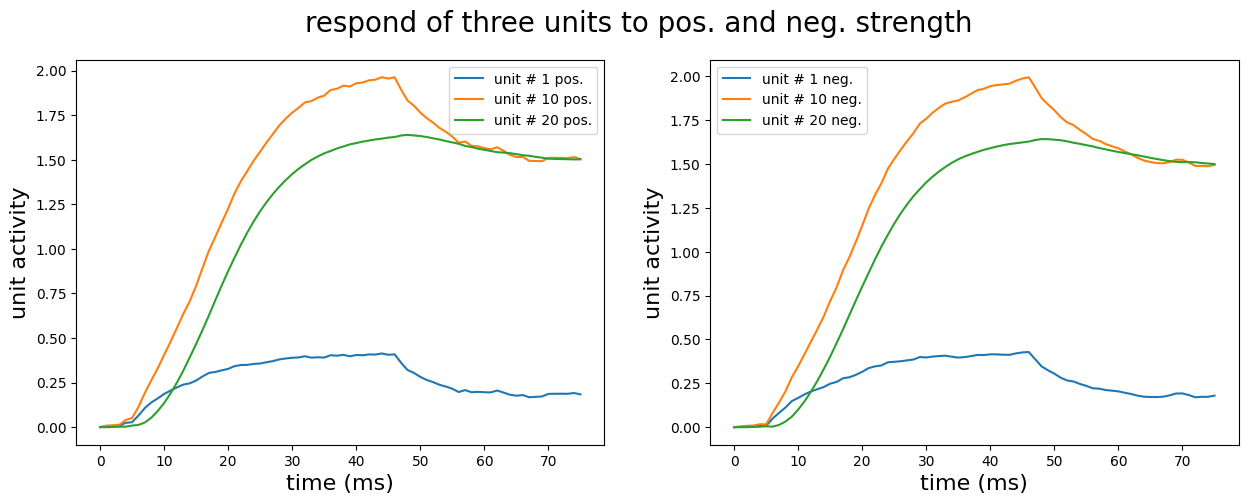

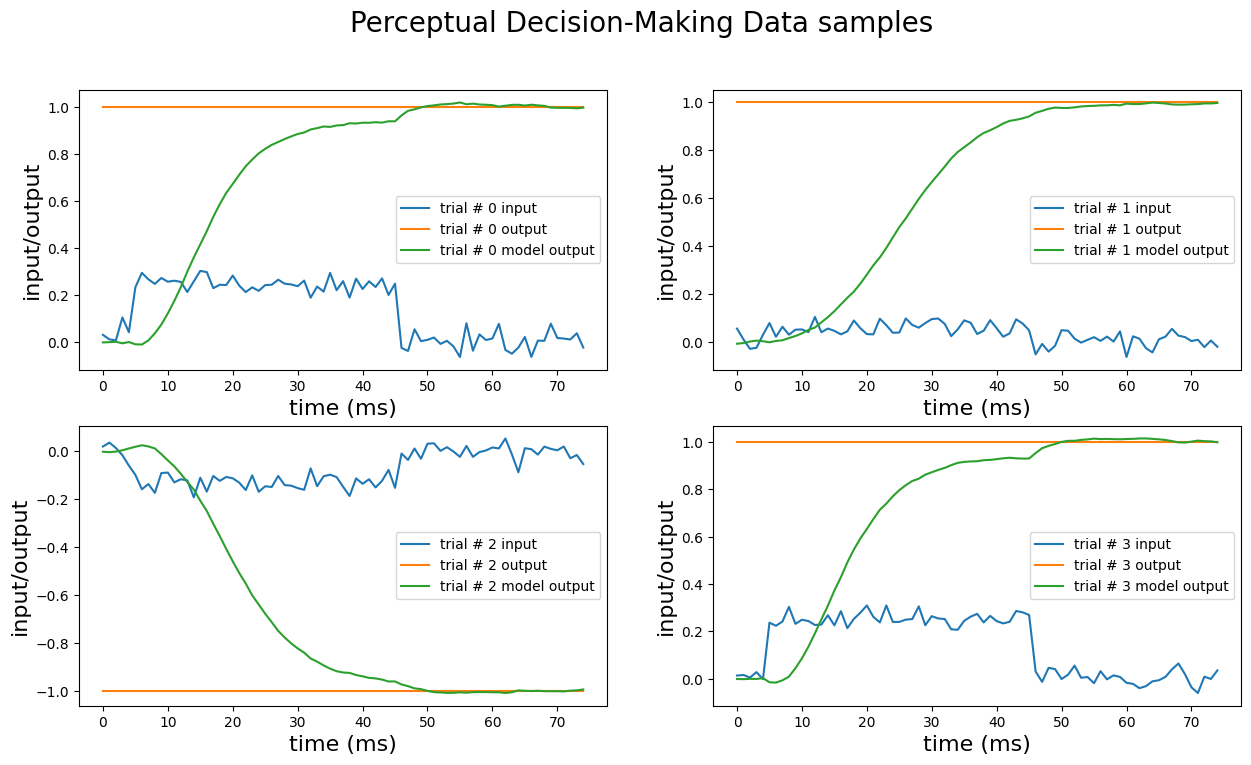

In [10]:

u_arr, y_arr = next(iter(d_dataloader))
unit_activity = model.forward(u_arr, visible_activity=True)[1].detach().numpy()
print("unit_activity shape: ", unit_activity.shape)
#choose 3 different units among 128 units
unit1=unit_activity[:,:,0]
unit2=unit_activity[:,:,10]
unit3=unit_activity[:,:,20]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.suptitle('respond of three units to pos. and neg. strength', fontsize=20)
plt.plot(unit1[0,:], label='unit # 1 pos.')
plt.plot(unit2[0,:], label='unit # 10 pos.' )
plt.plot(unit3[0,:], label='unit # 20 pos.')
plt.xlabel('time (ms)', fontsize=16)
plt.ylabel('unit activity', fontsize=16)
plt.legend()
plt.subplot(1,2,2)
plt.plot(unit1[3,:], label='unit # 1 neg.')
plt.plot(unit2[3,:], label='unit # 10 neg.')
plt.plot(unit3[3,:], label='unit # 20 neg.')
plt.xlabel('time (ms)', fontsize=16)
plt.ylabel('unit activity', fontsize=16)
plt.legend()



plt.figure(figsize=(15,8))
plt.suptitle('Perceptual Decision-Making Data samples', fontsize=20)
for idx in range(4):
    plt.subplot(2,2,idx+1)
    plt.plot(u_arr[idx,:], label='trial # {} input'.format(idx))
    plt.plot(y_arr[idx,:], label='trial # {} output'.format(idx))
    plt.plot(model(u_arr[idx,:].unsqueeze(0)).detach().numpy().squeeze(), label='trial # {} model output'.format(idx))
    plt.xlabel('time (ms)', fontsize=16)
    #dt = 20msb
    # plt.xticks(np.arange(0, 75, step=5), np.arange(0, 1500, step=100))
    plt.ylabel('input/output', fontsize=16)
    plt.legend()

[[ 0.23452548  0.57971511 -0.45794355]
 [ 0.          1.50638149  2.10108176]
 [ 0.          0.          0.96051029]]


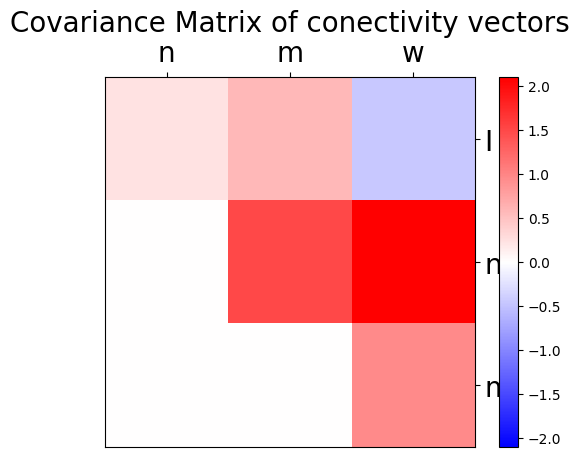

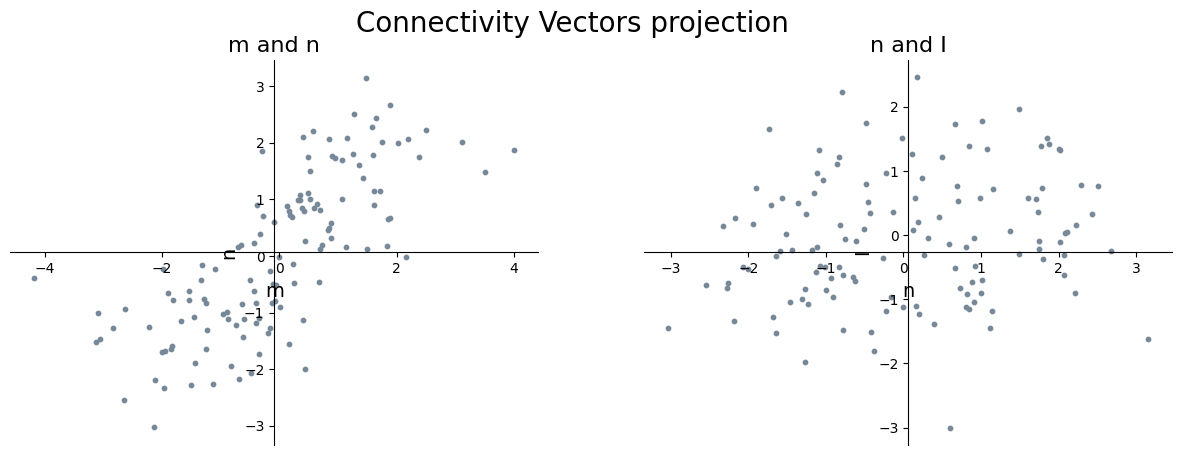

In [27]:
m=model.m.detach().numpy()
n=model.n.detach().numpy()
wi=model.wi.detach().numpy()
w=model.w.detach().numpy()
network_size=model.network_size
# m=-m
# n=-n
vectors = [wi, n, m, w]

cov_matrix=np.cov(vectors)

cov_matrix=np.triu(cov_matrix,1)
cov_matrix=cov_matrix[0:3,1:4]
bound = np.max((np.abs(np.min(cov_matrix)), np.abs(np.max(cov_matrix))))

print(cov_matrix)

plt.figure()
ax=plt.gca()
ax.yaxis.tick_right()
ax.xaxis.tick_top()
plt.title('Covariance Matrix of conectivity vectors', fontsize=20)
plt.imshow(cov_matrix,cmap= "bwr", vmin=-bound, vmax=bound)
ax.set_aspect('equal','box')
plt.xticks(np.arange(0, 3, step=1), ['n', 'm', 'w'], fontsize=20)
plt.yticks(np.arange(0, 3, step=1), ['I','n', 'm'], fontsize=20)
plt.colorbar()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Connectivity Vectors projection', fontsize=20)
# plt.suptitle('Connectivity Vectors projection', fontsize=20)
ax[0].set_title('m and n', fontsize=16)
ax[0].scatter(m, n,s=10, c= 'lightslategray')
ax[0].set_xlabel('m', fontsize=14)
ax[0].set_ylabel('n', fontsize=14)

ax[0].spines['left'].set_position('center')
ax[0].spines['bottom'].set_position('center')
# Eliminate upper and right axes
ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')
# Show ticks in the left and lower axes only
ax[0].xaxis.set_ticks_position('bottom')
ax[0].yaxis.set_ticks_position('left')

ax[1].set_title('n and I', fontsize=16)
ax[1].scatter(n, wi, s=10, c= 'lightslategray')
ax[1].set_xlabel('n', fontsize=14)
ax[1].set_ylabel('I', fontsize=14)

ax[1].spines['left'].set_position('center')
ax[1].spines['bottom'].set_position('center')
# Eliminate upper and right axes
ax[1].spines['right'].set_color('none')
ax[1].spines['top'].set_color('none')
# Show ticks in the left and lower axes only
ax[1].xaxis.set_ticks_position('bottom')
ax[1].yaxis.set_ticks_position('left')